<a href="https://colab.research.google.com/github/wolejnr/100-Days-of-Code-Journal/blob/master/Data_Viz_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Installing Python modules

In [2]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd 

!pip install plotly==4.5.0
import matplotlib.pyplot as plt   
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)

     |████████████████████████████████| 7.1MB 7.5MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy



# Step 2: Bring in the function we wrote from previous lesson

In [3]:
def scrape_table(Url):
    soup = BeautifulSoup(requests.get(Url).text)
    headers = [header.text for listing in soup.find_all('thead') for header in listing.find_all('th')]
    raw_data = {header:[] for header in headers}

    for rows in soup.find_all('tbody'):
      for row in rows.find_all('tr'):
        if len(row) != len(headers) or row.find_all('td')[3].text == '-': 
          continue
        for idx, cell in enumerate(row.find_all('td')):
          raw_data[headers[idx]].append(cell.text)

    return pd.DataFrame(raw_data)

# Step 3: Bring in the Python functions for datatype conversion 

In [4]:
def convert_column_to_float(df, columns):
  for column in columns: 
    df[column] = pd.to_numeric(df[column].str.replace(',',''))
  return df

def convert_column_to_datetime(df, columns):
  for column in columns:
    df[column] = pd.to_datetime(df[column])
  return df

def revert_scaled_number(number):
  mapping = {'M': 1000000, 'B': 1000000000, 'T': 1000000000000}
  scale = number[-1]
  return float(number[0:-1]) * mapping[scale]

# Examining the Apple stock

In [5]:
apple = scrape_table("https://finance.yahoo.com/quote/AAPL/history?p=AAPL")[0:90]
# TODO: use the data type conversion functions to convert the data columns
apple = convert_column_to_float(apple, apple.columns[1:])
apple = convert_column_to_datetime(apple, [apple.columns[0]])
apple

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2021-05-07,130.85,131.26,129.48,130.21,130.21,78892700
1,2021-05-06,127.89,129.75,127.13,129.74,129.52,78128300
2,2021-05-05,129.20,130.45,127.97,128.10,127.88,84000900
3,2021-05-04,131.19,131.49,126.70,127.85,127.63,137564700
4,2021-05-03,132.04,134.07,131.83,132.54,132.32,75135100
...,...,...,...,...,...,...,...
85,2021-01-05,128.89,131.74,128.43,131.01,130.59,97664900
86,2021-01-04,133.52,133.61,126.76,129.41,129.00,143301900
87,2020-12-31,134.08,134.74,131.72,132.69,132.27,99116600
88,2020-12-30,135.58,135.99,133.40,133.72,133.29,96452100


Text(0, 0.5, 'Price (USD)')

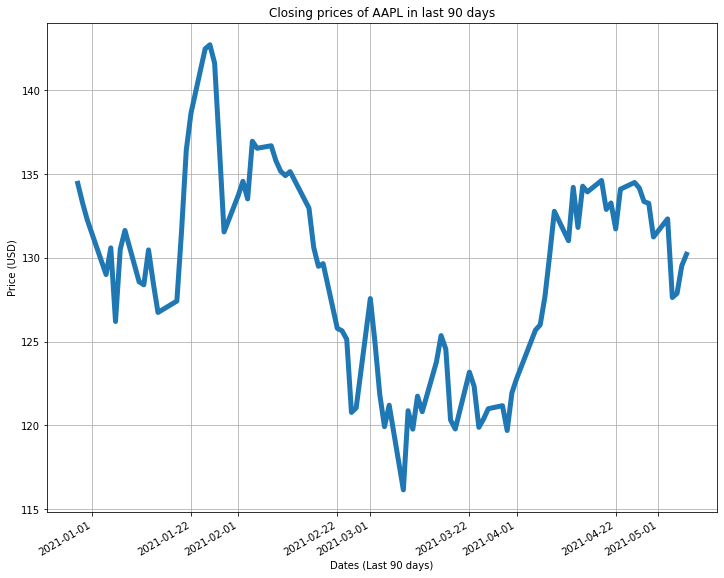

In [6]:
ts = pd.Series(apple["Adj Close**"].values, index=apple["Date"])
# TODO: plot the line chart using matplotlib
ts.plot(lw=5, kind='line', grid=True, title="Closing prices of AAPL in last 90 days")
plt.xlabel('Dates (Last 90 days)')
plt.ylabel('Price (USD)')

# Market share of Cryptocurrencies

In [7]:
df=scrape_table("https://finance.yahoo.com/cryptocurrencies?count=200&offset=0")
df = df.iloc[0:7, 0:]
df
df['Market Cap']=df['Market Cap'].apply(revert_scaled_number)
# TODO: aggregate the data and plot a pie chart showing the market cap distribution of cryptocurrencies
market_cap_sum = sum(df['Market Cap'])
df.loc[df['Market Cap']/market_cap_sum < 0.01, 'Name'] = 'Others'

fig = px.pie(df, values='Market Cap', names='Name', title="Market Share of Cryptocurrencies")
fig.show()

# Candlestick chart

In [8]:
# TODO: use plotly to plot a candlestick chart showing apple's stock history
fig = go.Figure(data=[go.Candlestick(
  x=apple['Date'],  
  open=apple['Open'],
  high=apple['High'],
  low=apple['Low'],
  close=apple['Close*']
)])

fig.update_layout(
    autosize=True,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue"
)

fig.show()

# Comparing multiple stocks

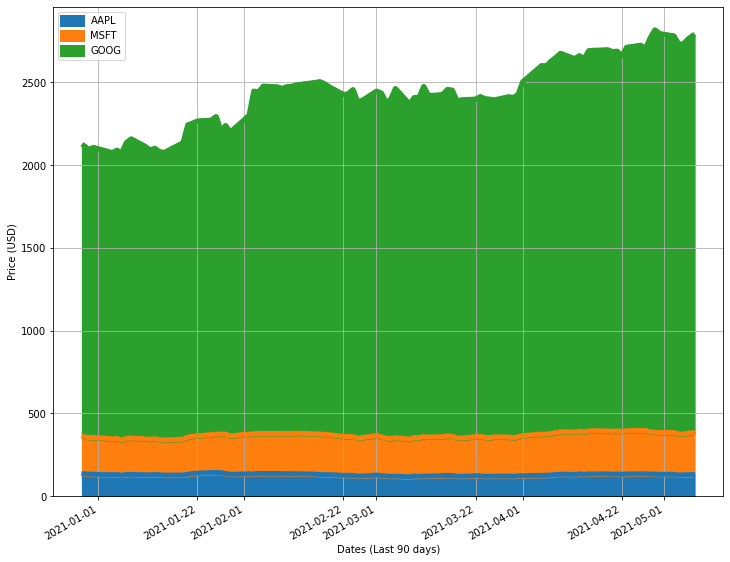

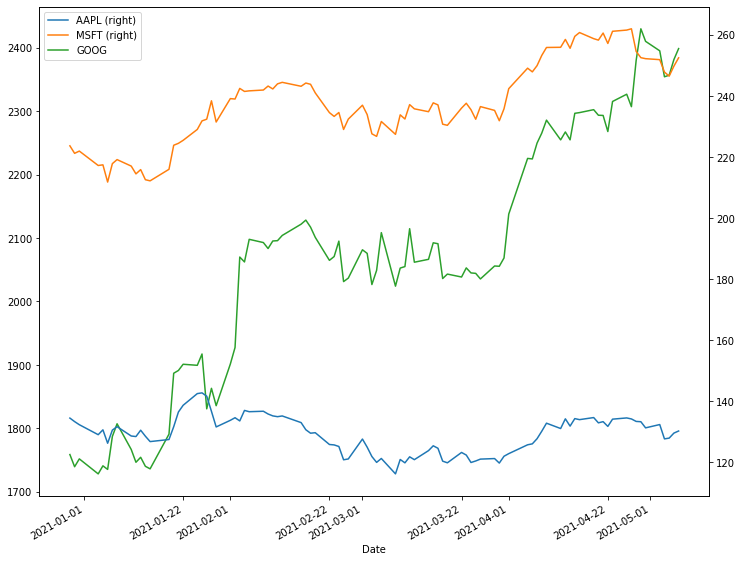

In [9]:
microsoft, google = (scrape_table("https://finance.yahoo.com/quote/"+s+"/history?p="+s)[0:90] for s in ["MSFT", "GOOG"])
microsoft, google = convert_column_to_float(microsoft, microsoft.columns[1:]), convert_column_to_float(google, google.columns[1:])
microsoft, google = convert_column_to_datetime(microsoft, [microsoft.columns[0]]), convert_column_to_datetime(google, [google.columns[0]])
 
# TODO: plot a multi-stock graph using matplotlib
stocks = pd.DataFrame({
    "AAPL": apple["Adj Close**"].values,
    "MSFT": microsoft["Adj Close**"].values,
    "GOOG": google["Adj Close**"].values
}, index=apple["Date"])
stocks.plot(lw=5, kind='area', grid=True)
plt.xlabel('Dates (Last 90 days)')
plt.ylabel('Price (USD)')
stocks.plot(secondary_y = ["AAPL", "MSFT"], kind='line')

# Heatmap of active stocks

In [10]:
activestocks = scrape_table("https://finance.yahoo.com/most-active?count=200&offset=0")
marketCaps = activestocks['Market Cap'].apply(revert_scaled_number)
percentChanges = activestocks['% Change'].str.replace('+','').str.replace('%','').astype(float)

In [13]:
# TODO: plot a heatmap showing the active stock data
fig = px.treemap(activestocks, 
                 title="Active stocks heatmap (Size=Market Cap, Color=Percent Change)",
                 path=['Symbol'],
                 values=marketCaps,
                 hover_name='Name',
                 hover_data=['Price (Intraday)', '% Change', 'Volume', 'Market Cap', 'PE Ratio (TTM)'],
                 color=percentChanges,
                 color_continuous_scale='RdYlGn',
                 range_color=[-5,5]
                 )

fig.update_layout(
    autosize=True,
    margin=dict(l=30,r=30,t=30,b=30),
    paper_bgcolor="White",
)

fig.show()

# Bubblechart of active stocks

In [14]:
activestocks = scrape_table("https://finance.yahoo.com/most-active?count=200&offset=0")
activestocks['Market Cap']=activestocks['Market Cap'].apply(revert_scaled_number)
activestocks['% Change']=activestocks['% Change'].str.replace('+','').str.replace('%','').astype(float)
activestocks['Price (Intraday)']=activestocks['Price (Intraday)'].str.replace(',','').astype(float)


# TODO: plot a bubble chart showing the active stock data
fig2 = px.scatter(activestocks, 
                  x="Price (Intraday)", 
                  y="% Change", 
                  size="Market Cap", 
                  color="Name",
                  hover_name="Name",
                  size_max=60)

fig2.update_layout (
    autosize=True,
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="White",
)
fig2.show()